# Computing the Brunt Vaisala Frequency with NUMBA

#### Author

    Eugenio Cutolo, SOCIB/IMEDEA

#### Context

    Work done in collaboration with the IGE/MEOM group

#### Purpose

    Write an efficent python module for computing the alfa and beta coefficents with different equations of state of the sea water and then the Brunt Vaisala frequency.
    Starting poin is an xarray containg temperature and salinity from NEMO (or ROMS) outputs.


#### Todo and Remarks
    - Clean the code
    - Improve performance through xarray DASK capability (i.e. using chunks)
    - Compare the results with a pure Fortran implementation
    - Implement an abstraction layer to compute N2 with both models ROMS and NEMO
        - check problems with different vertical discretization 
        - deal properly with horizontal mask
    - Check the physic of the results
        - EOS uses different kind of temperature/salinity
    - Compute the Rossby Radius of Deformation

### Modules

In [1]:
import numpy as np
import xarray as xr
from numba import njit

import gsw,numba

import functools,time
from contextlib import contextmanager
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib auto

Using matplotlib backend: Qt5Agg


In [2]:
print('numba version : ' + numba.__version__)
print('xarray version : ' + xr.__version__)

numba version : 0.36.2
xarray version : 0.10.4


### Parameterization of the State Equations (EOS)

In [3]:
EOS_PARAMETERS = {'TEOS10':{},'EOS08':{},'SEOS':{}}

EOS_PARAMETERS['SEOS']['T0'] = 10 
EOS_PARAMETERS['SEOS']['S0'] = 35
EOS_PARAMETERS['SEOS']['rn_a0'] = 1.6550e-1
EOS_PARAMETERS['SEOS']['rn_b0'] = 7.6554e-1
EOS_PARAMETERS['SEOS']['rn_lambda1'] = 5.9520e-2
EOS_PARAMETERS['SEOS']['rn_lambda2'] = 5.9520e-2
EOS_PARAMETERS['SEOS']['rn_mu1'] = 1.4970e-4
EOS_PARAMETERS['SEOS']['rn_mu2'] = 1.1090e-5
EOS_PARAMETERS['SEOS']['rn_nu'] = 2.4341e-3
EOS_PARAMETERS['SEOS']['r1_rau0'] = 1.0e-3

EOS_PARAMETERS['TEOS10']['r1_rau0'] = 1.0e-3
EOS_PARAMETERS['TEOS10']['rdeltaS'] = 32.0
EOS_PARAMETERS['TEOS10']['r1_S0'] = 0.875/35.16504
EOS_PARAMETERS['TEOS10']['r1_T0'] = 1./40.
EOS_PARAMETERS['TEOS10']['r1_Z0'] = 1.e-4
EOS_PARAMETERS['TEOS10']['EOS000'] = 8.0189615746e+02
EOS_PARAMETERS['TEOS10']['EOS100'] = 8.6672408165e+02
EOS_PARAMETERS['TEOS10']['EOS200'] = -1.7864682637e+03
EOS_PARAMETERS['TEOS10']['EOS300'] = 2.0375295546e+03
EOS_PARAMETERS['TEOS10']['EOS400'] = -1.2849161071e+03
EOS_PARAMETERS['TEOS10']['EOS500'] = 4.3227585684e+02
EOS_PARAMETERS['TEOS10']['EOS600'] = -6.0579916612e+01
EOS_PARAMETERS['TEOS10']['EOS010'] = 2.6010145068e+01
EOS_PARAMETERS['TEOS10']['EOS110'] = -6.5281885265e+01
EOS_PARAMETERS['TEOS10']['EOS210'] = 8.1770425108e+01
EOS_PARAMETERS['TEOS10']['EOS310'] = -5.6888046321e+01
EOS_PARAMETERS['TEOS10']['EOS410'] = 1.7681814114e+01
EOS_PARAMETERS['TEOS10']['EOS510'] = -1.9193502195
EOS_PARAMETERS['TEOS10']['EOS020'] = -3.7074170417e+01
EOS_PARAMETERS['TEOS10']['EOS120'] = 6.1548258127e+01
EOS_PARAMETERS['TEOS10']['EOS220'] = -6.0362551501e+01
EOS_PARAMETERS['TEOS10']['EOS320'] = 2.9130021253e+01
EOS_PARAMETERS['TEOS10']['EOS420'] = -5.4723692739
EOS_PARAMETERS['TEOS10']['EOS030'] = 2.1661789529e+01
EOS_PARAMETERS['TEOS10']['EOS130'] = -3.3449108469e+01
EOS_PARAMETERS['TEOS10']['EOS230'] = 1.9717078466e+01
EOS_PARAMETERS['TEOS10']['EOS330'] = -3.1742946532
EOS_PARAMETERS['TEOS10']['EOS040'] = -8.3627885467
EOS_PARAMETERS['TEOS10']['EOS140'] = 1.1311538584e+01
EOS_PARAMETERS['TEOS10']['EOS240'] = -5.3563304045
EOS_PARAMETERS['TEOS10']['EOS050'] = 5.4048723791e-01
EOS_PARAMETERS['TEOS10']['EOS150'] = 4.8169980163e-01
EOS_PARAMETERS['TEOS10']['EOS060'] = -1.9083568888e-01
EOS_PARAMETERS['TEOS10']['EOS001'] = 1.9681925209e+01
EOS_PARAMETERS['TEOS10']['EOS101'] = -4.2549998214e+01
EOS_PARAMETERS['TEOS10']['EOS201'] = 5.0774768218e+01
EOS_PARAMETERS['TEOS10']['EOS301'] = -3.0938076334e+01
EOS_PARAMETERS['TEOS10']['EOS401'] = 6.6051753097
EOS_PARAMETERS['TEOS10']['EOS011'] = -1.3336301113e+01
EOS_PARAMETERS['TEOS10']['EOS111'] = -4.4870114575
EOS_PARAMETERS['TEOS10']['EOS211'] = 5.0042598061
EOS_PARAMETERS['TEOS10']['EOS311'] = -6.5399043664e-01
EOS_PARAMETERS['TEOS10']['EOS021'] = 6.7080479603
EOS_PARAMETERS['TEOS10']['EOS121'] = 3.5063081279
EOS_PARAMETERS['TEOS10']['EOS221'] = -1.8795372996
EOS_PARAMETERS['TEOS10']['EOS031'] = -2.4649669534
EOS_PARAMETERS['TEOS10']['EOS131'] = -5.5077101279e-01
EOS_PARAMETERS['TEOS10']['EOS041'] = 5.5927935970e-01
EOS_PARAMETERS['TEOS10']['EOS002'] = 2.0660924175
EOS_PARAMETERS['TEOS10']['EOS102'] = -4.9527603989
EOS_PARAMETERS['TEOS10']['EOS202'] = 2.5019633244
EOS_PARAMETERS['TEOS10']['EOS012'] = 2.0564311499
EOS_PARAMETERS['TEOS10']['EOS112'] = -2.1311365518e-01
EOS_PARAMETERS['TEOS10']['EOS022'] = -1.2419983026
EOS_PARAMETERS['TEOS10']['EOS003'] = -2.3342758797e-02
EOS_PARAMETERS['TEOS10']['EOS103'] = -1.8507636718e-02
EOS_PARAMETERS['TEOS10']['EOS013'] = 3.7969820455e-01
EOS_PARAMETERS['TEOS10']['ALP000'] = -6.5025362670e-01
EOS_PARAMETERS['TEOS10']['ALP100'] = 1.6320471316
EOS_PARAMETERS['TEOS10']['ALP200'] = -2.0442606277
EOS_PARAMETERS['TEOS10']['ALP300'] = 1.4222011580
EOS_PARAMETERS['TEOS10']['ALP400'] = -4.4204535284e-01
EOS_PARAMETERS['TEOS10']['ALP500'] = 4.7983755487e-02
EOS_PARAMETERS['TEOS10']['ALP010'] = 1.8537085209
EOS_PARAMETERS['TEOS10']['ALP110'] = -3.0774129064
EOS_PARAMETERS['TEOS10']['ALP210'] = 3.0181275751
EOS_PARAMETERS['TEOS10']['ALP310'] = -1.4565010626
EOS_PARAMETERS['TEOS10']['ALP410'] = 2.7361846370e-01
EOS_PARAMETERS['TEOS10']['ALP020'] = -1.6246342147
EOS_PARAMETERS['TEOS10']['ALP120'] = 2.5086831352
EOS_PARAMETERS['TEOS10']['ALP220'] = -1.4787808849
EOS_PARAMETERS['TEOS10']['ALP320'] = 2.3807209899e-01
EOS_PARAMETERS['TEOS10']['ALP030'] = 8.3627885467e-01
EOS_PARAMETERS['TEOS10']['ALP130'] = -1.1311538584
EOS_PARAMETERS['TEOS10']['ALP230'] = 5.3563304045e-01
EOS_PARAMETERS['TEOS10']['ALP040'] = -6.7560904739e-02
EOS_PARAMETERS['TEOS10']['ALP140'] = -6.0212475204e-02
EOS_PARAMETERS['TEOS10']['ALP050'] = 2.8625353333e-02
EOS_PARAMETERS['TEOS10']['ALP001'] = 3.3340752782e-01
EOS_PARAMETERS['TEOS10']['ALP101'] = 1.1217528644e-01
EOS_PARAMETERS['TEOS10']['ALP201'] = -1.2510649515e-01
EOS_PARAMETERS['TEOS10']['ALP301'] = 1.6349760916e-02
EOS_PARAMETERS['TEOS10']['ALP011'] = -3.3540239802e-01
EOS_PARAMETERS['TEOS10']['ALP111'] = -1.7531540640e-01
EOS_PARAMETERS['TEOS10']['ALP211'] = 9.3976864981e-02
EOS_PARAMETERS['TEOS10']['ALP021'] = 1.8487252150e-01
EOS_PARAMETERS['TEOS10']['ALP121'] = 4.1307825959e-02
EOS_PARAMETERS['TEOS10']['ALP031'] = -5.5927935970e-02
EOS_PARAMETERS['TEOS10']['ALP002'] = -5.1410778748e-02
EOS_PARAMETERS['TEOS10']['ALP102'] = 5.3278413794e-03
EOS_PARAMETERS['TEOS10']['ALP012'] = 6.2099915132e-02
EOS_PARAMETERS['TEOS10']['ALP003'] = -9.4924551138e-03
EOS_PARAMETERS['TEOS10']['BET000'] = 1.0783203594e+01
EOS_PARAMETERS['TEOS10']['BET100'] = -4.4452095908e+01
EOS_PARAMETERS['TEOS10']['BET200'] = 7.6048755820e+01
EOS_PARAMETERS['TEOS10']['BET300'] = -6.3944280668e+01
EOS_PARAMETERS['TEOS10']['BET400'] = 2.6890441098e+01
EOS_PARAMETERS['TEOS10']['BET500'] = -4.5221697773
EOS_PARAMETERS['TEOS10']['BET010'] = -8.1219372432e-01
EOS_PARAMETERS['TEOS10']['BET110'] = 2.0346663041
EOS_PARAMETERS['TEOS10']['BET210'] = -2.1232895170
EOS_PARAMETERS['TEOS10']['BET310'] = 8.7994140485e-01
EOS_PARAMETERS['TEOS10']['BET410'] = -1.1939638360e-01
EOS_PARAMETERS['TEOS10']['BET020'] = 7.6574242289e-01
EOS_PARAMETERS['TEOS10']['BET120'] = -1.5019813020
EOS_PARAMETERS['TEOS10']['BET220'] = 1.0872489522
EOS_PARAMETERS['TEOS10']['BET320'] = -2.7233429080e-01
EOS_PARAMETERS['TEOS10']['BET030'] = -4.1615152308e-01
EOS_PARAMETERS['TEOS10']['BET130'] = 4.9061350869e-01
EOS_PARAMETERS['TEOS10']['BET230'] = -1.1847737788e-01
EOS_PARAMETERS['TEOS10']['BET040'] = 1.4073062708e-01
EOS_PARAMETERS['TEOS10']['BET140'] = -1.3327978879e-01
EOS_PARAMETERS['TEOS10']['BET050'] = 5.9929880134e-03
EOS_PARAMETERS['TEOS10']['BET001'] = -5.2937873009e-01
EOS_PARAMETERS['TEOS10']['BET101'] = 1.2634116779
EOS_PARAMETERS['TEOS10']['BET201'] = -1.1547328025
EOS_PARAMETERS['TEOS10']['BET301'] = 3.2870876279e-01
EOS_PARAMETERS['TEOS10']['BET011'] = -5.5824407214e-02
EOS_PARAMETERS['TEOS10']['BET111'] = 1.2451933313e-01
EOS_PARAMETERS['TEOS10']['BET211'] = -2.4409539932e-02
EOS_PARAMETERS['TEOS10']['BET021'] = 4.3623149752e-02
EOS_PARAMETERS['TEOS10']['BET121'] = -4.6767901790e-02
EOS_PARAMETERS['TEOS10']['BET031'] = -6.8523260060e-03
EOS_PARAMETERS['TEOS10']['BET002'] = -6.1618945251e-02
EOS_PARAMETERS['TEOS10']['BET102'] = 6.2255521644e-02
EOS_PARAMETERS['TEOS10']['BET012'] = -2.6514181169e-03
EOS_PARAMETERS['TEOS10']['BET003'] = -2.3025968587e-04
EOS_PARAMETERS['TEOS10']['PEN000'] = -9.8409626043
EOS_PARAMETERS['TEOS10']['PEN100'] = 2.1274999107e+01
EOS_PARAMETERS['TEOS10']['PEN200'] = -2.5387384109e+01
EOS_PARAMETERS['TEOS10']['PEN300'] = 1.5469038167e+01
EOS_PARAMETERS['TEOS10']['PEN400'] = -3.3025876549
EOS_PARAMETERS['TEOS10']['PEN010'] = 6.6681505563
EOS_PARAMETERS['TEOS10']['PEN110'] = 2.2435057288
EOS_PARAMETERS['TEOS10']['PEN210'] = -2.5021299030
EOS_PARAMETERS['TEOS10']['PEN310'] = 3.2699521832e-01
EOS_PARAMETERS['TEOS10']['PEN020'] = -3.3540239802
EOS_PARAMETERS['TEOS10']['PEN120'] = -1.7531540640
EOS_PARAMETERS['TEOS10']['PEN220'] = 9.3976864981e-01
EOS_PARAMETERS['TEOS10']['PEN030'] = 1.2324834767
EOS_PARAMETERS['TEOS10']['PEN130'] = 2.7538550639e-01
EOS_PARAMETERS['TEOS10']['PEN040'] = -2.7963967985e-01
EOS_PARAMETERS['TEOS10']['PEN001'] = -1.3773949450
EOS_PARAMETERS['TEOS10']['PEN101'] = 3.3018402659
EOS_PARAMETERS['TEOS10']['PEN201'] = -1.6679755496
EOS_PARAMETERS['TEOS10']['PEN011'] = -1.3709540999
EOS_PARAMETERS['TEOS10']['PEN111'] = 1.4207577012e-01
EOS_PARAMETERS['TEOS10']['PEN021'] = 8.2799886843e-01
EOS_PARAMETERS['TEOS10']['PEN002'] = 1.7507069098e-02
EOS_PARAMETERS['TEOS10']['PEN102'] = 1.3880727538e-02
EOS_PARAMETERS['TEOS10']['PEN012'] = -2.8477365341e-01
EOS_PARAMETERS['TEOS10']['APE000'] = -1.6670376391e-01
EOS_PARAMETERS['TEOS10']['APE100'] = -5.6087643219e-02
EOS_PARAMETERS['TEOS10']['APE200'] = 6.2553247576e-02
EOS_PARAMETERS['TEOS10']['APE300'] = -8.1748804580e-03
EOS_PARAMETERS['TEOS10']['APE010'] = 1.6770119901e-01
EOS_PARAMETERS['TEOS10']['APE110'] = 8.7657703198e-02
EOS_PARAMETERS['TEOS10']['APE210'] = -4.6988432490e-02
EOS_PARAMETERS['TEOS10']['APE020'] = -9.2436260751e-02
EOS_PARAMETERS['TEOS10']['APE120'] = -2.0653912979e-02
EOS_PARAMETERS['TEOS10']['APE030'] = 2.7963967985e-02
EOS_PARAMETERS['TEOS10']['APE001'] = 3.4273852498e-02
EOS_PARAMETERS['TEOS10']['APE101'] = -3.5518942529e-03
EOS_PARAMETERS['TEOS10']['APE011'] = -4.1399943421e-02
EOS_PARAMETERS['TEOS10']['APE002'] = 7.1193413354e-03
EOS_PARAMETERS['TEOS10']['BPE000'] = 2.6468936504e-01
EOS_PARAMETERS['TEOS10']['BPE100'] = -6.3170583896e-01
EOS_PARAMETERS['TEOS10']['BPE200'] = 5.7736640125e-01
EOS_PARAMETERS['TEOS10']['BPE300'] = -1.6435438140e-01
EOS_PARAMETERS['TEOS10']['BPE010'] = 2.7912203607e-02
EOS_PARAMETERS['TEOS10']['BPE110'] = -6.2259666565e-02
EOS_PARAMETERS['TEOS10']['BPE210'] = 1.2204769966e-02
EOS_PARAMETERS['TEOS10']['BPE020'] = -2.1811574876e-02
EOS_PARAMETERS['TEOS10']['BPE120'] = 2.3383950895e-02
EOS_PARAMETERS['TEOS10']['BPE030'] = 3.4261630030e-03
EOS_PARAMETERS['TEOS10']['BPE001'] = 4.1079296834e-02
EOS_PARAMETERS['TEOS10']['BPE101'] = -4.1503681096e-02
EOS_PARAMETERS['TEOS10']['BPE011'] = 1.7676120780e-03
EOS_PARAMETERS['TEOS10']['BPE002'] = 1.7269476440e-04

EOS_PARAMETERS['EOS08']['r1_rau0'] = 1.0e-3
EOS_PARAMETERS['EOS08']['rdeltaS'] = 20.
EOS_PARAMETERS['EOS08']['r1_S0'] = 1./40.
EOS_PARAMETERS['EOS08']['r1_T0'] = 1./40.
EOS_PARAMETERS['EOS08']['r1_Z0'] = 1.e-4
EOS_PARAMETERS['EOS08']['EOS000'] = 9.5356891948e+02
EOS_PARAMETERS['EOS08']['EOS100'] = 1.7136499189e+02
EOS_PARAMETERS['EOS08']['EOS200'] = -3.7501039454e+02
EOS_PARAMETERS['EOS08']['EOS300'] = 5.1856810420e+02
EOS_PARAMETERS['EOS08']['EOS400'] = -3.7264470465e+02
EOS_PARAMETERS['EOS08']['EOS500'] = 1.4302533998e+02
EOS_PARAMETERS['EOS08']['EOS600'] = -2.2856621162e+01
EOS_PARAMETERS['EOS08']['EOS010'] = 1.0087518651e+01
EOS_PARAMETERS['EOS08']['EOS110'] = -1.3647741861e+01
EOS_PARAMETERS['EOS08']['EOS210'] = 8.8478359933
EOS_PARAMETERS['EOS08']['EOS310'] = -7.2329388377
EOS_PARAMETERS['EOS08']['EOS410'] = 1.4774410611
EOS_PARAMETERS['EOS08']['EOS510'] = 2.0036720553e-01
EOS_PARAMETERS['EOS08']['EOS020'] = -2.5579830599e+01
EOS_PARAMETERS['EOS08']['EOS120'] = 2.4043512327e+01
EOS_PARAMETERS['EOS08']['EOS220'] = -1.6807503990e+01
EOS_PARAMETERS['EOS08']['EOS320'] = 8.3811577084
EOS_PARAMETERS['EOS08']['EOS420'] = -1.9771060192
EOS_PARAMETERS['EOS08']['EOS030'] = 1.6846451198e+01
EOS_PARAMETERS['EOS08']['EOS130'] = -2.1482926901e+01
EOS_PARAMETERS['EOS08']['EOS230'] = 1.0108954054e+01
EOS_PARAMETERS['EOS08']['EOS330'] = -6.2675951440e-01
EOS_PARAMETERS['EOS08']['EOS040'] = -8.0812310102
EOS_PARAMETERS['EOS08']['EOS140'] = 1.0102374985e+01
EOS_PARAMETERS['EOS08']['EOS240'] = -4.8340368631
EOS_PARAMETERS['EOS08']['EOS050'] = 1.2079167803
EOS_PARAMETERS['EOS08']['EOS150'] = 1.1515380987e-01
EOS_PARAMETERS['EOS08']['EOS060'] = -2.4520288837e-01
EOS_PARAMETERS['EOS08']['EOS001'] = 1.0748601068e+01
EOS_PARAMETERS['EOS08']['EOS101'] = -1.7817043500e+01
EOS_PARAMETERS['EOS08']['EOS201'] = 2.2181366768e+01
EOS_PARAMETERS['EOS08']['EOS301'] = -1.6750916338e+01
EOS_PARAMETERS['EOS08']['EOS401'] = 4.1202230403
EOS_PARAMETERS['EOS08']['EOS011'] = -1.5852644587e+01
EOS_PARAMETERS['EOS08']['EOS111'] = -7.6639383522e-01
EOS_PARAMETERS['EOS08']['EOS211'] = 4.1144627302
EOS_PARAMETERS['EOS08']['EOS311'] = -6.6955877448e-01
EOS_PARAMETERS['EOS08']['EOS021'] = 9.9994861860
EOS_PARAMETERS['EOS08']['EOS121'] = -1.9467067787e-01
EOS_PARAMETERS['EOS08']['EOS221'] = -1.2177554330
EOS_PARAMETERS['EOS08']['EOS031'] = -3.4866102017
EOS_PARAMETERS['EOS08']['EOS131'] = 2.2229155620e-01
EOS_PARAMETERS['EOS08']['EOS041'] = 5.9503008642e-01
EOS_PARAMETERS['EOS08']['EOS002'] = 1.0375676547
EOS_PARAMETERS['EOS08']['EOS102'] = -3.4249470629
EOS_PARAMETERS['EOS08']['EOS202'] = 2.0542026429
EOS_PARAMETERS['EOS08']['EOS012'] = 2.1836324814
EOS_PARAMETERS['EOS08']['EOS112'] = -3.4453674320e-01
EOS_PARAMETERS['EOS08']['EOS022'] = -1.2548163097
EOS_PARAMETERS['EOS08']['EOS003'] = 1.8729078427e-02
EOS_PARAMETERS['EOS08']['EOS103'] = -5.7238495240e-02
EOS_PARAMETERS['EOS08']['EOS013'] = 3.8306136687e-01
EOS_PARAMETERS['EOS08']['ALP000'] = -2.5218796628e-01
EOS_PARAMETERS['EOS08']['ALP100'] = 3.4119354654e-01
EOS_PARAMETERS['EOS08']['ALP200'] = -2.2119589983e-01
EOS_PARAMETERS['EOS08']['ALP300'] = 1.8082347094e-01
EOS_PARAMETERS['EOS08']['ALP400'] = -3.6936026529e-02
EOS_PARAMETERS['EOS08']['ALP500'] = -5.0091801383e-03
EOS_PARAMETERS['EOS08']['ALP010'] = 1.2789915300
EOS_PARAMETERS['EOS08']['ALP110'] = -1.2021756164
EOS_PARAMETERS['EOS08']['ALP210'] = 8.4037519952e-01
EOS_PARAMETERS['EOS08']['ALP310'] = -4.1905788542e-01
EOS_PARAMETERS['EOS08']['ALP410'] = 9.8855300959e-02
EOS_PARAMETERS['EOS08']['ALP020'] = -1.2634838399
EOS_PARAMETERS['EOS08']['ALP120'] = 1.6112195176
EOS_PARAMETERS['EOS08']['ALP220'] = -7.5817155402e-01
EOS_PARAMETERS['EOS08']['ALP320'] = 4.7006963580e-02
EOS_PARAMETERS['EOS08']['ALP030'] = 8.0812310102e-01
EOS_PARAMETERS['EOS08']['ALP130'] = -1.0102374985
EOS_PARAMETERS['EOS08']['ALP230'] = 4.8340368631e-01
EOS_PARAMETERS['EOS08']['ALP040'] = -1.5098959754e-01
EOS_PARAMETERS['EOS08']['ALP140'] = -1.4394226233e-02
EOS_PARAMETERS['EOS08']['ALP050'] = 3.6780433255e-02
EOS_PARAMETERS['EOS08']['ALP001'] = 3.9631611467e-01
EOS_PARAMETERS['EOS08']['ALP101'] = 1.9159845880e-02
EOS_PARAMETERS['EOS08']['ALP201'] = -1.0286156825e-01
EOS_PARAMETERS['EOS08']['ALP301'] = 1.6738969362e-02
EOS_PARAMETERS['EOS08']['ALP011'] = -4.9997430930e-01
EOS_PARAMETERS['EOS08']['ALP111'] = 9.7335338937e-03
EOS_PARAMETERS['EOS08']['ALP211'] = 6.0887771651e-02
EOS_PARAMETERS['EOS08']['ALP021'] = 2.6149576513e-01
EOS_PARAMETERS['EOS08']['ALP121'] = -1.6671866715e-02
EOS_PARAMETERS['EOS08']['ALP031'] = -5.9503008642e-02
EOS_PARAMETERS['EOS08']['ALP002'] = -5.4590812035e-02
EOS_PARAMETERS['EOS08']['ALP102'] = 8.6134185799e-03
EOS_PARAMETERS['EOS08']['ALP012'] = 6.2740815484e-02
EOS_PARAMETERS['EOS08']['ALP003'] = -9.5765341718e-03
EOS_PARAMETERS['EOS08']['BET000'] = 2.1420623987
EOS_PARAMETERS['EOS08']['BET100'] = -9.3752598635
EOS_PARAMETERS['EOS08']['BET200'] = 1.9446303907e+01
EOS_PARAMETERS['EOS08']['BET300'] = -1.8632235232e+01
EOS_PARAMETERS['EOS08']['BET400'] = 8.9390837485
EOS_PARAMETERS['EOS08']['BET500'] = -1.7142465871
EOS_PARAMETERS['EOS08']['BET010'] = -1.7059677327e-01
EOS_PARAMETERS['EOS08']['BET110'] = 2.2119589983e-01
EOS_PARAMETERS['EOS08']['BET210'] = -2.7123520642e-01
EOS_PARAMETERS['EOS08']['BET310'] = 7.3872053057e-02
EOS_PARAMETERS['EOS08']['BET410'] = 1.2522950346e-02
EOS_PARAMETERS['EOS08']['BET020'] = 3.0054390409e-01
EOS_PARAMETERS['EOS08']['BET120'] = -4.2018759976e-01
EOS_PARAMETERS['EOS08']['BET220'] = 3.1429341406e-01
EOS_PARAMETERS['EOS08']['BET320'] = -9.8855300959e-02
EOS_PARAMETERS['EOS08']['BET030'] = -2.6853658626e-01
EOS_PARAMETERS['EOS08']['BET130'] = 2.5272385134e-01
EOS_PARAMETERS['EOS08']['BET230'] = -2.3503481790e-02
EOS_PARAMETERS['EOS08']['BET040'] = 1.2627968731e-01
EOS_PARAMETERS['EOS08']['BET140'] = -1.2085092158e-01
EOS_PARAMETERS['EOS08']['BET050'] = 1.4394226233e-03
EOS_PARAMETERS['EOS08']['BET001'] = -2.2271304375e-01
EOS_PARAMETERS['EOS08']['BET101'] = 5.5453416919e-01
EOS_PARAMETERS['EOS08']['BET201'] = -6.2815936268e-01
EOS_PARAMETERS['EOS08']['BET301'] = 2.0601115202e-01
EOS_PARAMETERS['EOS08']['BET011'] = -9.5799229402e-03
EOS_PARAMETERS['EOS08']['BET111'] = 1.0286156825e-01
EOS_PARAMETERS['EOS08']['BET211'] = -2.5108454043e-02
EOS_PARAMETERS['EOS08']['BET021'] = -2.4333834734e-03
EOS_PARAMETERS['EOS08']['BET121'] = -3.0443885826e-02
EOS_PARAMETERS['EOS08']['BET031'] = 2.7786444526e-03
EOS_PARAMETERS['EOS08']['BET002'] = -4.2811838287e-02
EOS_PARAMETERS['EOS08']['BET102'] = 5.1355066072e-02
EOS_PARAMETERS['EOS08']['BET012'] = -4.3067092900e-03
EOS_PARAMETERS['EOS08']['BET003'] = -7.1548119050e-04
EOS_PARAMETERS['EOS08']['PEN000'] = -5.3743005340
EOS_PARAMETERS['EOS08']['PEN100'] = 8.9085217499
EOS_PARAMETERS['EOS08']['PEN200'] = -1.1090683384e+01
EOS_PARAMETERS['EOS08']['PEN300'] = 8.3754581690
EOS_PARAMETERS['EOS08']['PEN400'] = -2.0601115202
EOS_PARAMETERS['EOS08']['PEN010'] = 7.9263222935
EOS_PARAMETERS['EOS08']['PEN110'] = 3.8319691761e-01
EOS_PARAMETERS['EOS08']['PEN210'] = -2.0572313651
EOS_PARAMETERS['EOS08']['PEN310'] = 3.3477938724e-01
EOS_PARAMETERS['EOS08']['PEN020'] = -4.9997430930
EOS_PARAMETERS['EOS08']['PEN120'] = 9.7335338937e-02
EOS_PARAMETERS['EOS08']['PEN220'] = 6.0887771651e-01
EOS_PARAMETERS['EOS08']['PEN030'] = 1.7433051009
EOS_PARAMETERS['EOS08']['PEN130'] = -1.1114577810e-01
EOS_PARAMETERS['EOS08']['PEN040'] = -2.9751504321e-01
EOS_PARAMETERS['EOS08']['PEN001'] = -6.9171176978e-01
EOS_PARAMETERS['EOS08']['PEN101'] = 2.2832980419
EOS_PARAMETERS['EOS08']['PEN201'] = -1.3694684286
EOS_PARAMETERS['EOS08']['PEN011'] = -1.4557549876
EOS_PARAMETERS['EOS08']['PEN111'] = 2.2969116213e-01
EOS_PARAMETERS['EOS08']['PEN021'] = 8.3654420645e-01
EOS_PARAMETERS['EOS08']['PEN002'] = -1.4046808820e-02
EOS_PARAMETERS['EOS08']['PEN102'] = 4.2928871430e-02
EOS_PARAMETERS['EOS08']['PEN012'] = -2.8729602515e-01
EOS_PARAMETERS['EOS08']['APE000'] = -1.9815805734e-01
EOS_PARAMETERS['EOS08']['APE100'] = -9.5799229402e-03
EOS_PARAMETERS['EOS08']['APE200'] = 5.1430784127e-02
EOS_PARAMETERS['EOS08']['APE300'] = -8.3694846809e-03
EOS_PARAMETERS['EOS08']['APE010'] = 2.4998715465e-01
EOS_PARAMETERS['EOS08']['APE110'] = -4.8667669469e-03
EOS_PARAMETERS['EOS08']['APE210'] = -3.0443885826e-02
EOS_PARAMETERS['EOS08']['APE020'] = -1.3074788257e-01
EOS_PARAMETERS['EOS08']['APE120'] = 8.3359333577e-03
EOS_PARAMETERS['EOS08']['APE030'] = 2.9751504321e-02
EOS_PARAMETERS['EOS08']['APE001'] = 3.6393874690e-02
EOS_PARAMETERS['EOS08']['APE101'] = -5.7422790533e-03
EOS_PARAMETERS['EOS08']['APE011'] = -4.1827210323e-02
EOS_PARAMETERS['EOS08']['APE002'] = 7.1824006288e-03
EOS_PARAMETERS['EOS08']['BPE000'] = 1.1135652187e-01
EOS_PARAMETERS['EOS08']['BPE100'] = -2.7726708459e-01
EOS_PARAMETERS['EOS08']['BPE200'] = 3.1407968134e-01
EOS_PARAMETERS['EOS08']['BPE300'] = -1.0300557601e-01
EOS_PARAMETERS['EOS08']['BPE010'] = 4.7899614701e-03
EOS_PARAMETERS['EOS08']['BPE110'] = -5.1430784127e-02
EOS_PARAMETERS['EOS08']['BPE210'] = 1.2554227021e-02
EOS_PARAMETERS['EOS08']['BPE020'] = 1.2166917367e-03
EOS_PARAMETERS['EOS08']['BPE120'] = 1.5221942913e-02
EOS_PARAMETERS['EOS08']['BPE030'] = -1.3893222263e-03
EOS_PARAMETERS['EOS08']['BPE001'] = 2.8541225524e-02
EOS_PARAMETERS['EOS08']['BPE101'] = -3.4236710714e-02
EOS_PARAMETERS['EOS08']['BPE011'] = 2.8711395266e-03
EOS_PARAMETERS['EOS08']['BPE002'] = 5.3661089288e-04

### Utility Functions

In [4]:
def numba_switch(numba_on):
    if numba_on:
        def wrapper(func):
            @functools.wraps(func)
            def _(*args, **kwargs):
                func_to_call = func
                return func_to_call(*args, **kwargs)
            return _
    else:
        def wrapper(func):
            @functools.wraps(func)
            def _(*args, **kwargs):
                func_to_call = njit(func)
                return func_to_call(*args, **kwargs)
            return _
    return wrapper

In [5]:
@contextmanager
def timeit_context(name):
    startTime = time.time()
    yield
    elapsedTime = time.time() - startTime
    print('{} takes {} ms'.format(name, int(elapsedTime * 1000))+'\n')

### EOS implementation to compute Alfa and Beta

In [6]:
def get_eos_ab_function(eos_name,with_numba=True):
    ns = numba_switch(with_numba)
    
    if eos_name in EOS_PARAMETERS:
        eos_parameters = namedtuple('eos_parameters',EOS_PARAMETERS[eos_name].keys())
        P = eos_parameters(*EOS_PARAMETERS[eos_name].values())
        
    if eos_name is 'SEOS':                  
        @ns
        def ab(T,S,zh):
            zt  = T - P.T0   # pot. temperature anomaly (t-T0)
            zs  = S - P.S0   # abs. salinity anomaly (s-S0)
            ztm = 1                  # land/sea bottom mask = surf. mask
            zn  = P.rn_a0 * ( 1. + P.rn_lambda1*zt + P.rn_mu1*zh ) + P.rn_nu*zs
            alfa = zn * P.r1_rau0 * ztm   # alpha
            zn  = P.rn_b0 * ( 1. - P.rn_lambda2*zs - P.rn_mu2*zh ) - P.rn_nu*zt
            beta = zn * P.r1_rau0 * ztm   # beta
            return alfa,beta
        
    elif eos_name is 'TEOS10' or eos_name is 'EOS08':
        @ns
        def ab(T,S,depth):
            zh  = depth * P.r1_Z0                       # depth
            zt  = T * P.r1_T0                         # temperature
            zs  = np.sqrt( np.abs( S + P.rdeltaS ) * P.r1_S0 )# square root salinity
            ztm = 1                                         # tmask
            
            #Alfa
            zn3 = P.ALP003
            zn2 = P.ALP012*zt + P.ALP102*zs+P.ALP002
            zn1 = ((P.ALP031*zt   \
                        + P.ALP121*zs+P.ALP021)*zt   \
                        + (P.ALP211*zs+P.ALP111)*zs+P.ALP011)*zt   \
                        + ((P.ALP301*zs+P.ALP201)*zs+P.ALP101)*zs+P.ALP001

            zn0 = ((((P.ALP050*zt   \
                        + P.ALP140*zs+P.ALP040)*zt   \
                        + (P.ALP230*zs+P.ALP130)*zs+P.ALP030)*zt   \
                        + ((P.ALP320*zs+P.ALP220)*zs+P.ALP120)*zs+P.ALP020)*zt   \
                        + (((P.ALP410*zs+P.ALP310)*zs+P.ALP210)*zs+P.ALP110)*zs+P.ALP010)*zt   \
                        + ((((P.ALP500*zs+P.ALP400)*zs+P.ALP300)*zs+P.ALP200)*zs+P.ALP100)*zs+P.ALP000
            zn  = ( ( zn3 * zh + zn2 ) * zh + zn1 ) * zh + zn0

            alfa = zn * P.r1_rau0 * ztm

            #Beta
            zn3 = P.BET003
            zn2 = P.BET012*zt + P.BET102*zs+P.BET002
            zn1 = ((P.BET031*zt   \
                    + P.BET121*zs+P.BET021)*zt   \
                    + (P.BET211*zs+P.BET111)*zs+P.BET011)*zt   \
                    + ((P.BET301*zs+P.BET201)*zs+P.BET101)*zs+P.BET001

            zn0 = ((((P.BET050*zt   \
                    + P.BET140*zs+P.BET040)*zt   \
                    + (P.BET230*zs+P.BET130)*zs+P.BET030)*zt   \
                    + ((P.BET320*zs+P.BET220)*zs+P.BET120)*zs+P.BET020)*zt   \
                    + (((P.BET410*zs+P.BET310)*zs+P.BET210)*zs+P.BET110)*zs+P.BET010)*zt   \
                    + ((((P.BET500*zs+P.BET400)*zs+P.BET300)*zs+P.BET200)*zs+P.BET100)*zs+P.BET000
            zn  = ( ( zn3 * zh + zn2 ) * zh + zn1 ) * zh + zn0

            beta = zn / zs * P.r1_rau0 * ztm

            return alfa,beta

    else:
        raise RuntimeError('This EOS is not availabe')
    return ab

### N2 Function for NEMO data

In [7]:
@njit
def compute_N2_natl60(T,S,a,b,gdepw_n,gdept_n,e3w_n):
    zrw = ( gdepw_n[1:-1,:] - gdept_n[1:-1,:])  / ( gdept_n[0:-2,:] - gdept_n[1:-1,:] ) 
    zaw = a[1:-1,:] * (1. - zrw) + a[0:-2,:] * zrw 
    zbw = b[1:-1,:] * (1. - zrw) + b[0:-2,:] * zrw
    pn2 = 9.8 * (  zaw * ( T[0:-2,:] - T[1:-1,:] ) \
                            - zbw * ( S[0:-2,:] - S[1:-1,:] )) \
                            / 1 #* wmask(ji,jj,jk)
    
    return pn2

### Test with Nemo data

#### Location of netcdf files


In [8]:
mesh_filename = '/LOCALDATA/ecutolo/NATL60_OUTPUTS/NATL60MED_mesh_zgr.nc'
filename = "/LOCALDATA/ecutolo/NATL60_OUTPUTS/NATL60MEDext-CJM165_y2013m05d01.1d_TS.nc"

#### Loading data

In [9]:
mesh = xr.open_dataset(mesh_filename)
lat = mesh.nav_lat[:,0]
lon = mesh.nav_lon[0,:]
mesh = mesh.sel(x=np.logical_and(lon>1,lon<5)).sel(y=np.logical_and(lat>38,lat<40))

In [10]:
ds = xr.open_dataset(filename)
lat = ds.nav_lat[:,0]
lon = ds.nav_lon[0,:]
ds = ds.isel(time_counter=0).sel(x=np.logical_and(lon>1,lon<5)).sel(y=np.logical_and(lat>40,lat<43))

In [11]:
zh, S, T = ds.deptht, ds.vosaline, ds.votemper
zh2,T2 = xr.broadcast(zh,T)

#### N.B.: This is not the correct way to deal with the mesh

In [12]:
gdept_n,zt2 = xr.broadcast(mesh.gdept_0[0,:],T)
gdept_n = gdept_n[:,0,:]
gdepw_n,zt2 = xr.broadcast(mesh.gdepw_0[0,:],T)
gdepw_n = gdepw_n[:,0,:]

#### Computing the time necessary for the N2 computation using different eos

In [13]:
N2 = {}
for e in EOS_PARAMETERS.keys():
    eos_ab = get_eos_ab_function(e,with_numba=True)
    with timeit_context('Computing N2 with {0}'.format(e)):
        a,b = eos_ab(T.values,S.values,zh2)
        N2[e] = compute_N2_natl60(T.values,S.values,a.values,b.values,gdepw_n.values,gdept_n.values,mesh.e3w.values)

Computing N2 with TEOS10 takes 3908 ms

Computing N2 with EOS08 takes 2143 ms

Computing N2 with SEOS takes 910 ms



#### Computing the time necessary for the N2 computation using gsw module

In [14]:
with timeit_context('Computing N2 with GSW'):
    SA = gsw.SA_from_SP(S,-zh2,ds.nav_lon,ds.nav_lat)
    CT = gsw.CT_from_pt(SA,T)
    N2['gsw'] = gsw.Nsquared(CT,SA,-zh2)[0][1:]

Computing N2 with GSW takes 1644 ms



#### Plot an example of N2 vertical profile

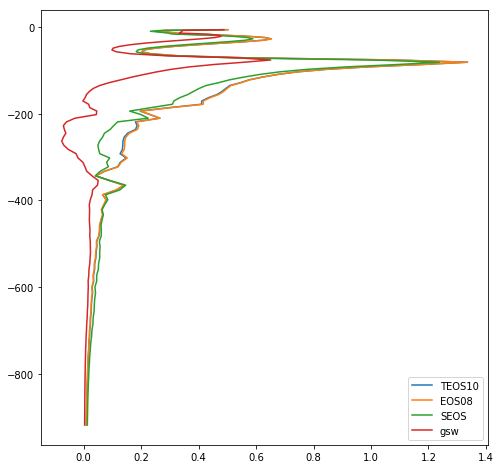

In [15]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
for e in N2:
    p1 = ax.plot(N2[e][2:100,100,100]*60*60,-zh[4:102], label=e)
ax.legend()

Why gsw results present negative values?

In [16]:
(N2['gsw'][2:100,100,100]*3600).min()

-0.07586885842304304